In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, TimeDistributed, Dense, Concatenate, dot, Activation
from tensorflow.keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
import pickle

In [ ]:

df_source = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/whole_data.csv', dtype = 'string')
# df_source = df_source.dropna()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/eval_total_dataset.csv", dtype=str)

In [ ]:
df_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496295 entries, 0 to 496294
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   correct         496295 non-null  string
 1   incorrect       496295 non-null  string
 2   correct_input   496295 non-null  string
 3   correct_output  496295 non-null  string
dtypes: string(4)
memory usage: 15.1 MB


In [ ]:
df_source.drop('Unnamed: 0', axis = 1)

KeyError: ignored

In [ ]:
df_source

,input,target
0,So I think we can not live if old people could...,So I think we would not be alive if our ancest...
1,So I think we can not live if old people could...,So I think we could not live if older people d...
2,So I think we can not live if old people could...,So I think we can not live if old people could...
3,So I think we can not live if old people could...,So I think we can not live if old people can n...
4,For not use car .,Not for use with a car .
...,...,...
67640,I’m not keen on Ahley’s statement – it attempt...,I’m not keen on Ahley’s statement – it attempt...
67641,If all the service vendors provided the whom t...,If all of the service vendors provided the typ...
67642,How Features can I inspection?,What Features Will I Find?
67643,The trend towards American style proms turned ...,The trend towards American style proms has tur...


In [ ]:
df_source = df_source.rename(columns = {'input': 'incorrect', 'target':'correct'})

In [ ]:
df_source

,correct,incorrect,correct_input,correct_output
0,And he took in my favorite subjects like soccer .,And he took in my favorite subject like soccer .,<sos> And he took in my favorite subjects like...,And he took in my favorite subjects like socce...
1,"Actually , he was the one who let me know abou...","Actually , who let me know about Lang was him .","<sos> Actually , he was the one who let me kno...","Actually , he was the one who let me know abou..."
2,His Kanji ability is much better than mine .,His Kanji's ability is much better than me .,<sos> His Kanji ability is much better than mi...,His Kanji ability is much better than mine . <...
3,We have known each other for only half a year ...,We have known each other for only half a year ...,<sos> We have known each other for only half a...,We have known each other for only half a year ...
4,I heard a sentence last night when I was watch...,I heard a sentence last night when I watched TV .,<sos> I heard a sentence last night when I was...,I heard a sentence last night when I was watch...
...,...,...,...,...
496290,"I like Thai , because the pronunciation sounds...","I like Thailand language , because that pronou...","<sos> I like Thai , because the pronunciation ...","I like Thai , because the pronunciation sounds..."
496291,"I ate kaomangai rice with boiled chickin , t...","I ate kaomangai rise with boild chikin , tom...",<sos> I ate kaomangai rice with boiled chicki...,"I ate kaomangai rice with boiled chickin , t..."
496292,I think it is important to like coriander in o...,I think it is important thing to become to lik...,<sos> I think it is important to like coriande...,I think it is important to like coriander in o...
496293,I went to Umeda station for dating yesterday .,"Yesterday , I went to Umeda station to date .",<sos> I went to Umeda station for dating yeste...,I went to Umeda station for dating yesterday ....


In [ ]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

In [ ]:
tkn_all = Tokenizer(filters='', lower=False, split= ' ', oov_token = "<OOV>", char_level = False)
tkn_all.fit_on_texts(df_source['incorrect'] + df_source['correct'])

In [ ]:

start_token = '<sos>'
stop_token = '<eos>'

len(tkn_all.word_index)


144142

In [ ]:
tkn_all.word_index = {word: index + 1 for index, word in enumerate(tkn_all.word_index)}
tkn_all.word_index[start_token] = 144143
tkn_all.word_index[stop_token] = 144144
tkn_all.index_word[144143] = '<sos>'
tkn_all.index_word[144144] = '<eos>'

In [ ]:
st_token = tkn_all.word_index['<sos>']
ed_token = tkn_all.word_index['<eos>']

In [ ]:
tkn_all.index_word[1230]

'camera'

In [ ]:
with open('tokenizer_jfleg_conll14.pickle', 'wb') as handle:
    pickle.dump(tkn_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def preprocessing_df_corr(df, col, mxlen):
    seq = tkn_all.texts_to_sequences(start_token + " " + df[col]+ " "+ stop_token)
    seq_padded = pad_sequences(seq, maxlen = mxlen, padding = 'post', truncating= 'post')
    return seq_padded

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(df_source, test_size = 0.2, random_state = 200)

In [ ]:
train.shape

(397036, 4)

In [ ]:
vocab_size = len(tkn_all.word_index) + 1

In [ ]:
inc_train_seq = preprocessing_df_corr(train,'incorrect', 32)
inc_test_seq =preprocessing_df_corr(test,'incorrect', 32)
# inc_cv_seq = preprocessing_df_corr(cv,'incorrect', 32)

# corr_inp_train_seq = preprocessing_df(train,'correct_input', 32)
# corr_inp_test_seq =preprocessing_df(test,'correct_input', 32)
# corr_inp_cv_seq = preprocessing_df(cv,'correct_input', 32)

# corr_out_train_seq = preprocessing_df(train,'correct_output', 32)
# corr_out_test_seq =preprocessing_df(test,'correct_output', 32)
# corr_out_cv_seq = preprocessing_df(cv,'correct_output', 32)

# corr_train_seq = preprocessing_df(train,'correct', 32)
# corr_test_seq = preprocessing_df(test,'correct', 32)
# corr_cv_seq = preprocessing_df(cv,'correct', 32)

corr_train_seq = preprocessing_df_corr(train,'correct', 32)
corr_test_seq = preprocessing_df_corr(test,'correct', 32)
# corr_cv_seq = preprocessing_df_corr(cv,'correct', 32)

In [ ]:
encoder_units = 32
decoder_units = 32
embedding_dim = 32

In [ ]:
# Define the encoder model
encoder_inputs = Input(shape=(inc_train_seq.shape[1],))
encoder_embedding = Embedding(vocab_size, embedding_dim, input_length=inc_train_seq.shape[1])(encoder_inputs)
encoder = LSTM(encoder_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embedding)
encoder_states = [state_h, state_c]

# Define the decoder model

# decoder_embedding = Embedding(vocab_size, embedding_dim)
# decoder_embedded = decoder_embedding(decoder_inputs)

decoder = LSTM(decoder_units, return_sequences=True, return_state=True)
decoder_outputs = decoder(encoder_embedding, initial_state=encoder_states)[0]

# Attention Mechanism
attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)

context = dot([attention, encoder_outputs], axes=[2,1])
decoder_combined_context = Concatenate()([context, decoder_outputs])

# Dense layer for prediction
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_combined_context)

model = Model(inputs=encoder_inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 32)       4612640     ['input_2[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  [(None, 32, 32),     8320        ['embedding_1[0][0]']            
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                            

In [ ]:
for layer in model.layers:
        print("Layer Name: " + layer.name)
        print("Type of layer: " + layer.__class__.__name__)
        print("Input dimesion: {}".format(layer.input_shape[1:]))
        print("Output dimesion: {}".format(layer.output_shape[1:]))
        print("Parameter Count: {}".format( layer.count_params()))
        try:
            print("Activation : " + layer.activation.__name__)
            print(" ")
        except:
            print(" ")

Layer Name: input_2
Type of layer: InputLayer
Input dimesion: []
Output dimesion: []
Parameter Count: 0
 
Layer Name: embedding_1
Type of layer: Embedding
Input dimesion: (32,)
Output dimesion: (32, 32)
Parameter Count: 4612640
 
Layer Name: lstm_2
Type of layer: LSTM
Input dimesion: (32, 32)
Output dimesion: [(None, 32), (None, 32)]
Parameter Count: 8320
Activation : tanh
 
Layer Name: lstm_3
Type of layer: LSTM
Input dimesion: [(None, 32), (None, 32)]
Output dimesion: [(None, 32), (None, 32)]
Parameter Count: 8320
Activation : tanh
 
Layer Name: dot_2
Type of layer: Dot
Input dimesion: [(None, 32, 32)]
Output dimesion: (32, 32)
Parameter Count: 0
 
Layer Name: attention
Type of layer: Activation
Input dimesion: (32, 32)
Output dimesion: (32, 32)
Parameter Count: 0
Activation : softmax
 
Layer Name: dot_3
Type of layer: Dot
Input dimesion: [(None, 32, 32)]
Output dimesion: (32, 32)
Parameter Count: 0
 
Layer Name: concatenate_1
Type of layer: Concatenate
Input dimesion: [(None, 32, 32

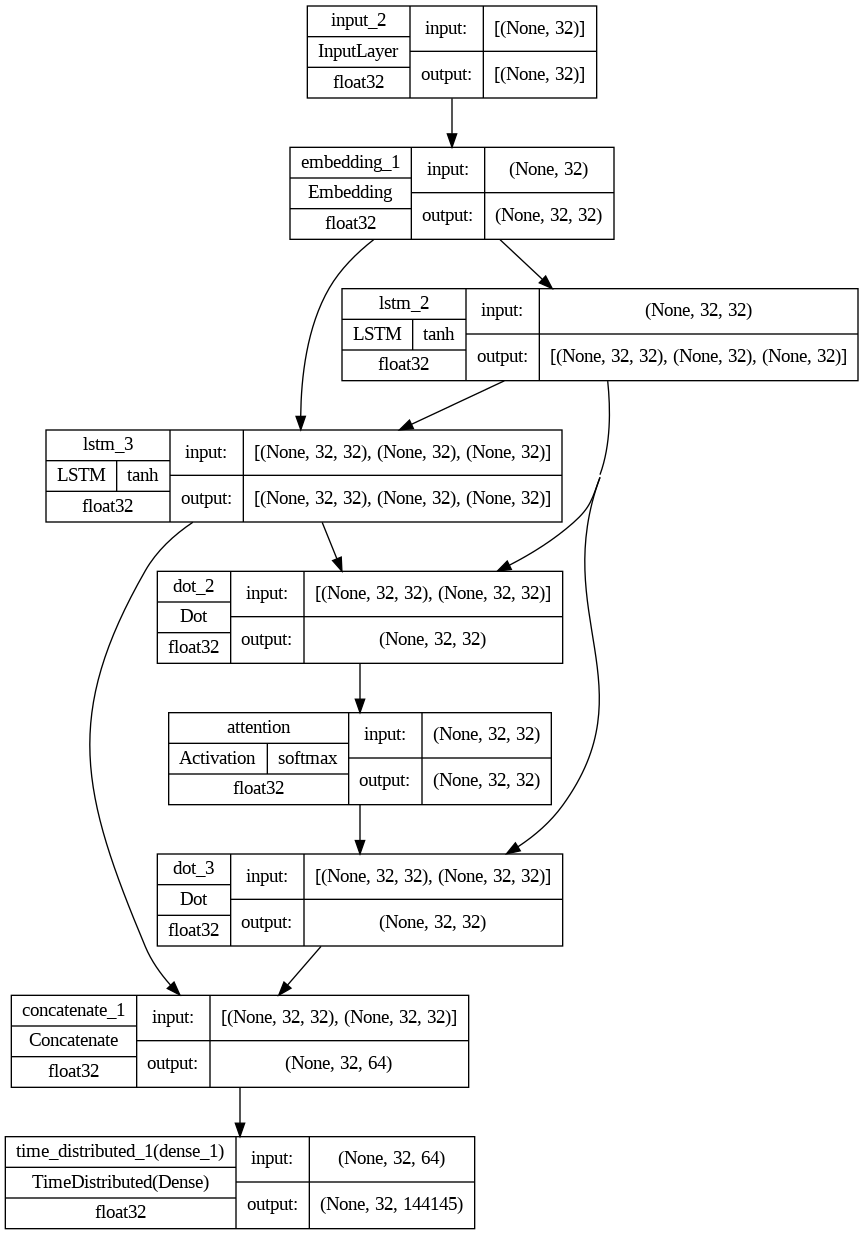

In [ ]:
#Keras visualization
import tensorflow as tf
model_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_img_file, 
                          show_shapes=True, 
                          show_layer_activations=True, 
                          show_dtype=True,
                          show_layer_names=True )

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
from keras.callbacks import CSVLogger

In [ ]:
log_csv = CSVLogger('logs.csv', separator=",", append=False)

In [ ]:
import re
def correct_sentence(sentence):
    sequence = tkn_all.texts_to_sequences([start_token + " " + sentence + " " + stop_token])
    padded = pad_sequences(sequence, maxlen=inc_train_seq.shape[1], padding = 'post', truncating = 'post')
    encoded = model.predict(padded)
    y = np.argmax(encoded, axis = 2)
    y = np.reshape(y, (1,32))
    decoded = []
    decoded_np = np.ndarray(32)
    for i in range(encoded.shape[1]):
        word_index = np.argmax(encoded[0, i, :])
        decoded_np = np.append(decoded_np,word_index)
        if word_index > 0:
            decoded.append(tkn_all.index_word[word_index])
            if word_index == tkn_all.word_index[stop_token]:
                break
        else:
            decoded.append('<OOV>')
    return ' '.join(decoded)


def correctAllsentences(input_sentences, target_sentences):
  target_value = target_sentences
  value = []
  for i in input_sentences:
    sen = correct_sentence(i)
    sen = sen.replace("<OOV>" , "")
    sen = sen.replace("<sos>", "")
    sen = sen.replace("<eos>", "")
    sen = re.sub(" +", " " , sen)
    if sen[0] == " ":
      sen = sen[1:]
    value.append(sen)
  return value, target_value


In [ ]:
candidate, references = correctAllsentences(df['input'][:10], df['target'][0:10])

1/1 [==============================] - 0s 20ms/step


In [ ]:
from nltk.translate.bleu_score import sentence_bleu 
def calculate_bleu(candidate, references):
  bleu_score = []
  for i in range(len(candidate)):
      score = sentence_bleu(references, candidate, weights=(1,0,0,0))
      bleu_score.append(score)
  return bleu_score

calculate_bleu(candidate, references)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [ ]:
import csv
class CustomCallback(keras.callbacks.Callback):
  def __init__(self, candidates=[], references=[]):
    self.candidates, self.references = correctAllsentences(df['input'][:10], df['target'][0:10])
    self.bleu_list = []
    self.epoch_list = []
  def on_epoch_end(self, epoch, logs=None):
    keys = list(logs.keys())
    bleu_score = calculate_bleu(self.candidates, self.references)
    print("\nThe bleu Score is  {} ".format(epoch), sum(bleu_score)/ len(bleu_score))
    self.bleu_list.append(sum(bleu_score)/ len(bleu_score))
    self.epoch_list.append(epoch)
  def on_train_end(self, logs=None):
    print(self.bleu_list)
    print(self.epoch_list)
    with open('data.csv', 'w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Epoch', 'Bleu'])

      for i in range(len(self.epoch_list)):
          writer.writerow([self.epoch_list, self.bleu_list])



In [ ]:
bleu_callback = CustomCallback(candidate, references)

In [ ]:
history = model.fit(inc_train_seq, corr_train_seq, epochs=10, batch_size=4, verbose = 1, validation_split = 0.2,callbacks=[log_csv])

Epoch 1/10
    68/147092 [..............................] - ETA: 25:39:35 - loss: 13.9511 - accuracy: 0.3619

KeyboardInterrupt: ignored

In [ ]:
 #evaluate the model
test_loss = model.evaluate(inc_test_seq, corr_test_seq, verbose = 0)

# Extract accuracy from training history
test_acc = history.history['val_accuracy'][-1]
print("Test Accuracy:", test_acc)
print('Test Loss:', test_loss)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
model.save('/content/drive/MyDrive/models/grammar_corrector_atten_25epo.h5')